# Imports 

In [9]:
%matplotlib inline
import numpy as np
import cv2
from incisorseg.dataset import Dataset,LeaveOneOutSplitter,load_image,load_landmark,gaussian_pyramid_down
from incisorseg.utils import *
from active_shape_models.shape import Shape, ShapeList
from active_shape_models.models import GreyModel,PointDistributionModel,ActiveShapeModel
from active_shape_models.pca import PCAModel

# Reading data

In [2]:
data = Dataset('../data/')

0.975929


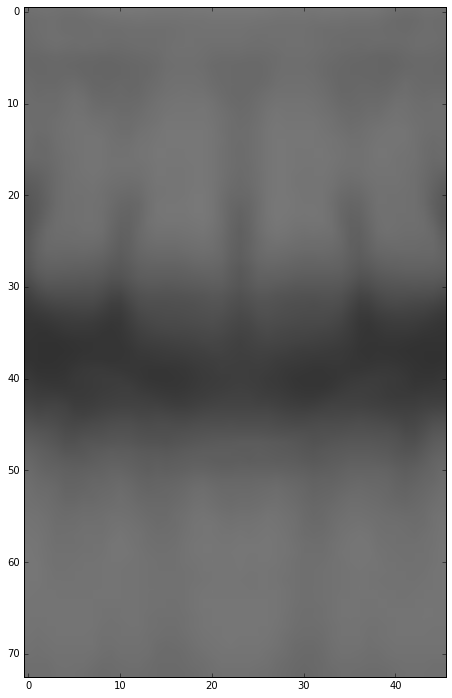

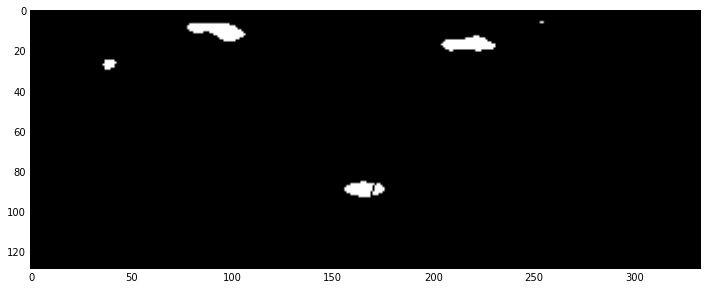

In [48]:
i = 0
pyr_levels = 4
for split in LeaveOneOutSplitter(data):
    if i>0:
        break
    training_images,training_landmarks,training_segmentations = split.get_training_set()
    test_image,test_landmark,test_segmentation = split.get_test_example()
    scaled_training_images,scaled_training_landmarks,scaled_test_image,scaled_test_landmark = gaussian_pyramid_down(
        training_images, training_landmarks, test_image, test_landmark, 4)
    shape_model = PointDistributionModel(scaled_training_landmarks)
    all_bounding_box_diff = np.squeeze(np.uint32(np.round(np.diff(scaled_training_landmarks.get_mean_shape().get_bounding_box(),axis=0))))
    datalist = []
    for j in range(len(scaled_training_landmarks)):
        shape_bbox = np.uint32(np.round(scaled_training_landmarks[j].get_bounding_box()))
        cropped = scaled_training_images[j][shape_bbox[0,1]:shape_bbox[1,1],shape_bbox[0,0]:shape_bbox[1,0]]
        img = cv2.resize(cropped,(all_bounding_box_diff[0],all_bounding_box_diff[1]))
        datalist.append(img)
    X = np.uint8(np.mean(np.array(datalist),axis=0))
    imshow2(X)
    ret = cv2.matchTemplate(scaled_test_image,X,method=cv2.TM_CCORR_NORMED)
    print np.max(np.max(ret))
    imshow2(overlay_shapes_on_image(255*np.uint8(ret>0.97),[shape_model.get_mean_shape_projected()]))
    i+=1
        
    
    
    

# Point Distribution Model

In [4]:
'''
lc,mlc = data.get_training_image_landmarks(Dataset.ALL_TRAINING_IMAGES,Dataset.ALL_TEETH)
landmarks = lc.concatenate(mlc)
model = PointDistributionModel(landmarks)
plot_shapes(model.get_aligned_shapes())
plot_shapes([model.get_mean_shape()])
plot_shapes(model.generate_mode_shapes(1))
plot_shapes(model.generate_mode_shapes(2))
plot_shapes(model.generate_mode_shapes(3))
'''

'\nlc,mlc = data.get_training_image_landmarks(Dataset.ALL_TRAINING_IMAGES,Dataset.ALL_TEETH)\nlandmarks = lc.concatenate(mlc)\nmodel = PointDistributionModel(landmarks)\nplot_shapes(model.get_aligned_shapes())\nplot_shapes([model.get_mean_shape()])\nplot_shapes(model.generate_mode_shapes(1))\nplot_shapes(model.generate_mode_shapes(2))\nplot_shapes(model.generate_mode_shapes(3))\n'

# Ideal case - testing the shape model fitting

In [5]:
'''
errors = []
for split in LeaveOneOutSplitter(data):
    training_images,training_landmarks,training_segmentations = split.get_training_set()
    test_image,test_landmark,test_segmentation = split.get_test_example()
    shape_model = PointDistributionModel(training_landmarks,pca_variance_captured=0.98)
    fitted_shape,_,num_iters =shape_model.fit(test_landmark)
    errors.append(split.get_dice_error_on_test(fitted_shape))
print np.mean(np.array(errors))
'''

'\nerrors = []\nfor split in LeaveOneOutSplitter(data):\n    training_images,training_landmarks,training_segmentations = split.get_training_set()\n    test_image,test_landmark,test_segmentation = split.get_test_example()\n    shape_model = PointDistributionModel(training_landmarks,pca_variance_captured=0.98)\n    fitted_shape,_,num_iters =shape_model.fit(test_landmark)\n    errors.append(split.get_dice_error_on_test(fitted_shape))\nprint np.mean(np.array(errors))\n'

# Ideal case - testing the grey model fitting

In [6]:
'''
pyr_levels=4
error_list = []
for split in LeaveOneOutSplitter(data):
    training_images,training_landmarks,training_segmentations = split.get_training_set()
    test_image,test_landmark,test_segmentation = split.get_test_example()
    scaled_training_images = training_images
    scaled_training_landmarks = training_landmarks
    scaled_test_image = test_image
    scaled_test_landmark = test_landmark
    for j in range(0,pyr_levels):
        scaled_test_image = cv2.pyrDown(scaled_test_image)
        scaled_test_landmark = scaled_test_landmark.pyr_down()
        scaled_training_images = [cv2.pyrDown(image) for image in scaled_training_images]
        scaled_training_landmarks=ShapeList([shape.pyr_down() for shape in scaled_training_landmarks])
    shape_model = PointDistributionModel(scaled_training_landmarks,pca_variance_captured=0.9)
    transformed_test_image = scaled_test_image
    transformed_training_images = scaled_training_images
    #transformed_training_images = [cv2.Laplacian(image,ddepth=cv2.CV_32F) for image in scaled_training_images]
    #transformed_test_image = cv2.Laplacian(scaled_test_image,ddepth=cv2.CV_32F)
    #transformed_training_images = [cv2.medianBlur(image,3) for image in scaled_training_images]
    #transformed_test_image = cv2.medianBlur(scaled_test_image,3)
    grey_model = GreyModel(transformed_training_images, scaled_training_landmarks,patch_num_pixels=5*(5-pyr_levels), 
                           search_num_pixels=10*(5-pyr_levels), use_gradient=False,
                 normalize_patch=False, use_moded_pca_model=False, mpca_variance_captured=0.9,
                 normal_point_neighborhood=2)
    fitted_shape,_ =grey_model.search(transformed_test_image,scaled_test_landmark.round())
    fitted_shape,_,_=shape_model.fit(fitted_shape)
    #plot_shapes([scaled_test_landmark,fitted_shape])
    for j in range(0,pyr_levels):
        fitted_shape = fitted_shape.pyr_up()
    error_list.append(split.get_dice_error_on_test(fitted_shape))
    #plot_shapes([test_landmark,fitted_shape])
print np.mean(np.array(error_list))
'''

'\npyr_levels=4\nerror_list = []\nfor split in LeaveOneOutSplitter(data):\n    training_images,training_landmarks,training_segmentations = split.get_training_set()\n    test_image,test_landmark,test_segmentation = split.get_test_example()\n    scaled_training_images = training_images\n    scaled_training_landmarks = training_landmarks\n    scaled_test_image = test_image\n    scaled_test_landmark = test_landmark\n    for j in range(0,pyr_levels):\n        scaled_test_image = cv2.pyrDown(scaled_test_image)\n        scaled_test_landmark = scaled_test_landmark.pyr_down()\n        scaled_training_images = [cv2.pyrDown(image) for image in scaled_training_images]\n        scaled_training_landmarks=ShapeList([shape.pyr_down() for shape in scaled_training_landmarks])\n    shape_model = PointDistributionModel(scaled_training_landmarks,pca_variance_captured=0.9)\n    transformed_test_image = scaled_test_image\n    transformed_training_images = scaled_training_images\n    #transformed_training_ima

In [7]:
'''
i = 0
pyr_levels = 4
for split in LeaveOneOutSplitter(data):
    if i >=1:
        pass#break
    training_images,training_landmarks,training_segmentations = split.get_training_set()
    test_image,test_landmark,test_segmentation = split.get_test_example()
    scaled_training_images = []
    scaled_training_landmarks = []
    scaled_test_images = []
    scaled_test_landmarks = []
    scaled_training_images.append(training_images)
    scaled_training_landmarks.append(ShapeList([ShapeList.from_shape(landmark,1)[0] for landmark in training_landmarks]))
    scaled_test_images.append(test_image)
    scaled_test_landmarks.append(ShapeList.from_shape(test_landmark,1)[0])
    for j in range(1,pyr_levels):
        scaled_test_images.append(cv2.pyrDown(scaled_test_images[j-1]))
        scaled_test_landmarks.append(scaled_test_landmarks[j-1].pyr_down())
        scaled_training_images.append([cv2.pyrDown(image) for image in scaled_training_images[j-1]])
        scaled_training_landmarks.append(ShapeList([shape.pyr_down() for shape in scaled_training_landmarks[j-1]]))
    new_shape = None
    #print 'Test Landmarks Accuracy %f',split.get_dice_error_on_test(test_landmark)
    detected_shapes = []
    for j in range(pyr_levels-1,-1,-1):
        shape_model = PointDistributionModel(scaled_training_landmarks[j],pca_variance_captured=0.9)
        grey_model = GreyModel(scaled_training_images[j],scaled_training_landmarks[j],
                               patch_num_pixels=5*(pyr_levels-j),
                               search_num_pixels=7*(pyr_levels-j))
        model = ActiveShapeModel(grey_model=grey_model,point_distribution_model=shape_model)
        new_shape,fit_error,num_iters = model.fit(scaled_test_images[j],0.5,100, initial_shape=new_shape)
        if j == pyr_levels-1:     
            detected_shapes.append(model.get_default_initial_shape())
        detected_shapes.append(new_shape)
        if j == 0:
            imshow2(overlay_shapes_on_image(scaled_test_images[j],[new_shape.round()]))
        #plot_shapes([new_shape])
        new_shape = new_shape.pyr_up()
    i +=1
    for j in range(len(detected_shapes)):
        if j==0:
            scale_start = 1
        else:
            scale_start = j
        for k in range(scale_start,pyr_levels):
            detected_shapes[j]=detected_shapes[j].pyr_up()
        
        print 'Level:' , j, 'Accuracy',split.get_dice_error_on_test(detected_shapes[j])
    '''
                

"\ni = 0\npyr_levels = 4\nfor split in LeaveOneOutSplitter(data):\n    if i >=1:\n        pass#break\n    training_images,training_landmarks,training_segmentations = split.get_training_set()\n    test_image,test_landmark,test_segmentation = split.get_test_example()\n    scaled_training_images = []\n    scaled_training_landmarks = []\n    scaled_test_images = []\n    scaled_test_landmarks = []\n    scaled_training_images.append(training_images)\n    scaled_training_landmarks.append(ShapeList([ShapeList.from_shape(landmark,1)[0] for landmark in training_landmarks]))\n    scaled_test_images.append(test_image)\n    scaled_test_landmarks.append(ShapeList.from_shape(test_landmark,1)[0])\n    for j in range(1,pyr_levels):\n        scaled_test_images.append(cv2.pyrDown(scaled_test_images[j-1]))\n        scaled_test_landmarks.append(scaled_test_landmarks[j-1].pyr_down())\n        scaled_training_images.append([cv2.pyrDown(image) for image in scaled_training_images[j-1]])\n        scaled_trainin